In [3]:
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [4]:
n = 127
k = 2
A = gallery.helmholtz((n, n), k)

In [5]:
gmm = gmg_linear.LinearGMG(A, max_levels=3)
gmm.compute_rho()

0.19743600294267599

(128,)
(127, 127)
(16129, 1)
(16129, 1)
2.1137209776e-11
6.29598994704e-05


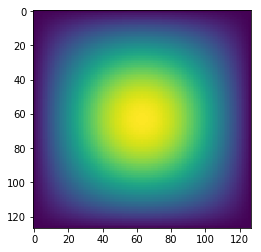

In [6]:
x0 = np.random.randn(A.shape)
x = np.linspace(0, 1, num=n+1, endpoint=False)
y = np.linspace(0, 1, num=n+1, endpoint=False)
print(x.shape)
xx, yy = np.meshgrid(x[1:], y[1:])
print(xx.shape)
x_true = np.sin(np.pi * xx) * np.sin(np.pi * yy)
rhs = (2 * np.pi**2 - k**2) * x_true / (n+1)**2
plt.imshow(rhs)
rhs = rhs.reshape(A.shape, 1)
print(rhs.shape)
x = gmm.solve(rhs, x0, tol=1e-10)
print(x.shape)
print(np.linalg.norm(A.dot(x) - rhs))
print(np.linalg.norm(x - x_true.reshape(A.shape, 1)) / np.linalg.norm(x_true.reshape(A.shape, 1)))

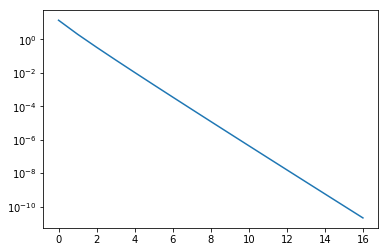

In [7]:
plt.semilogy(gmm.get_gmg_convergence())

In [8]:
x = x.reshape(A.dim)
print(x.shape)

(127, 127)


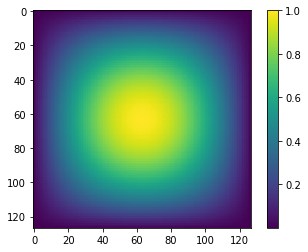

In [9]:
plt.imshow(x)
plt.colorbar()

## Utility functions

In [2]:
def plot_rhos(ks, rhos_linear, rhos_amg, rhos_opt=None):
    plt.plot(ks, rhos_linear, label="Linear")
    plt.plot(ks, rhos_amg, label="AMG")
    if rhos_opt:
        plt.plot(ks, rhos_opt, label="DMG")
    plt.xlabel("$k$")
    plt.yscale("log")
    plt.ylabel("Spectral radius")
    plt.legend()

## 1D
### Direct optimization for low frequency

In [45]:
num_levels = 2
n = 63
ks = [5 * i for i in range(1, 5)]
rhos_linear = []
rhos_amg = []
print("Test ks: {}".format(ks))
for k in ks:
    print("Current k = {}".format(k))
    A = gallery.helmholtz((n, ), k=k)
    linear_gmg = gmg_linear.LinearGMG(A, max_levels=num_levels)
    rhos_linear.append(linear_gmg.compute_rho())
    amg = classical_amg.ClassicalAMG(A, num_levels)
    rhos_amg.append(amg.compute_rho())
print("Linear = {}".format(rhos_linear))
print("AMG = {}".format(rhos_amg))

Test ks: [5, 10, 15, 20]
Current k = 5
Current k = 10
Current k = 15
Current k = 20
Linear = [0.062642839690208091, 0.06551390377379987, 0.16146847525800057, 0.17836694202778872]
AMG = [0.061726538462044268, 0.061697854736088159, 0.061622300282547497, 0.061727940442547882]


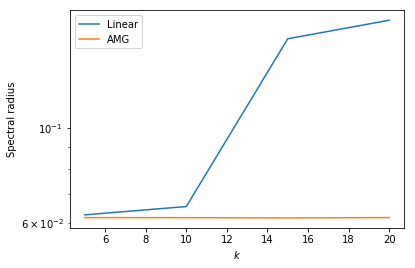

In [46]:
plot_rhos(ks, rhos_linear, rhos_amg)

In [47]:
rhos_opt = []
K = 20
batch_size = 10
num_iter = 2500
step_size = 5e-5
path2file = "../data/helmholtz_1d"
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
for k in ks:
    print("Current k = {}".format(k))
    A = gallery.helmholtz((n, ), k=k)
    deep_gmm = dgmg.DeepMG(A, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
#     print(deep_gmm)
    opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)
    opt_par_n[k] = opt_par
    convergence[k] = deep_gmm.get_optimizer_convergence()
    conv_time[k] = deep_gmm.get_optimization_time()
    deep_gmm.update_prd(opt_par)
    current_rho = deep_gmm.compute_rho()
    rhos_opt.append(current_rho)
    print("Optimized rho = {}".format(current_rho))
if init_point:
    init_type = "random"
else:
    init_type = "linear"

Current k = 5
Iteration 100/2500
Upper bound estimation = 0.059229582803375695
Iteration 200/2500
Upper bound estimation = 0.05606981610695427
Iteration 300/2500
Upper bound estimation = 0.05376919524190583
Iteration 400/2500
Upper bound estimation = 0.0514780218891428
Iteration 500/2500
Upper bound estimation = 0.050363389257830696
Iteration 600/2500
Upper bound estimation = 0.04992508892824817
Iteration 700/2500
Upper bound estimation = 0.048618461227473264
Iteration 800/2500
Upper bound estimation = 0.046824497303197356
Iteration 900/2500
Upper bound estimation = 0.0456294556365493
Iteration 1000/2500
Upper bound estimation = 0.04435529539395491
Iteration 1100/2500
Upper bound estimation = 0.043117134950474006
Iteration 1200/2500
Upper bound estimation = 0.04340792211177586
Iteration 1300/2500
Upper bound estimation = 0.04127195630295942
Iteration 1400/2500
Upper bound estimation = 0.04086464935136907
Iteration 1500/2500
Upper bound estimation = 0.04003657476636734
Iteration 1600/25

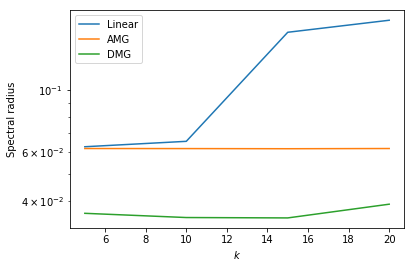

In [48]:
plot_rhos(ks, rhos_linear, rhos_amg, rhos_opt)

In [31]:
path2file = path2file + "_K_" + str(K) + "_iter_" + str(num_iter) + \
        "_step_" + str(step_size) + "_bs_" + str(batch_size) + \
        "_krange_" + str(min(ks)) + "_" + str(max(ks)) + "_N_" + str(n) + "_init_type_" + init_type + \
        "_stencil_type_" + PR_stencil_type + "_num_levels_" + str(num_levels) + ".npz"
np.savez(path2file, 
         PRdopt_n=opt_par_n, K=K, step_size=step_size, num_iter=num_iter, N=n, ks=ks, 
         convergence=convergence, batch_size=batch_size, num_levels=num_levels,
         conv_time=conv_time, init_type=init_type, stencil_type=PR_stencil_type)

### Homotopy based optimization for high frequency

In [3]:
num_levels = 3
m = 11
n = 2**m - 1
ks = [100 * i for i in range(1, 11)]
rhos_linear = []
rhos_amg = []
print("Test ks: {}".format(ks))
for k in ks:
    print("Current k = {}".format(k))
    A = gallery.helmholtz((n, ), k=k)
    linear_gmg = gmg_linear.LinearGMG(A, max_levels=num_levels)
    rhos_linear.append(linear_gmg.compute_rho())
    amg = classical_amg.ClassicalAMG(A, num_levels)
    rhos_amg.append(amg.compute_rho())
print(rhos_linear)
print(rhos_amg)

Test ks: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Current k = 100
Current k = 200
Current k = 300
Current k = 400
Current k = 500
Current k = 600
Current k = 700
Current k = 800
Current k = 900
Current k = 1000
[0.22783918880769227, 1.1419603624558214, 3.413780700250383, 8.1919945069529376, 30.492265661901001, 28.13936644165765, 37.75437494042059, 1894.0004771693041, 142.72390377337888, 4428.6127300931321]
[0.082615396517187911, 0.082526959154125334, 0.082375592232057135, 0.082154410261777056, 0.11681488365224209, 0.2144187848069182, 0.39582858390553105, 0.7583142477205308, 1.555157345523106, 3.5418174473372432]


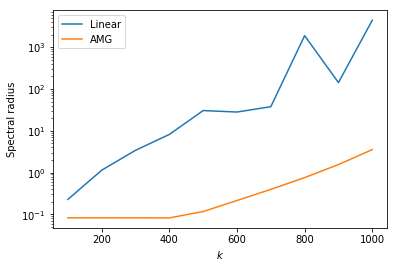

In [4]:
plt.semilogy(ks, rhos_linear, label="Linear")
plt.semilogy(ks, rhos_amg, label="AMG")
plt.xlabel("$k$")
plt.ylabel("Spectral radius")
plt.legend()

In [5]:
rhos_opt = []
K = 10
batch_size = 30
num_iter = 300
adam_step_size = 1e-4
PR_stencil_type = "m3p"
init_point = None

homotopy_step_size = 0.1
acceptance_limit = 1 + 2
homotopy_arg = "matrix" # objective
acceptance_arg = "obj_ratio" # "rho" "objective"

convergence = {}
opt_par_n = {}
conv_time = {}
A_init = gallery.poisson((n,)) * (n + 1)**2
for k in ks:
    print("Current k = {}".format(k))
    A = gallery.helmholtz((n, ), k=k) * (n + 1)**2
#     print("Init matrix")
#     print(A.get_matrix())
    deep_gmm = dgmg.DeepMG(A, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
    opt_par = deep_gmm.homotopy_optimize(A_init=A_init, homotopy_arg=homotopy_arg, 
                                         homotopy_step_size=homotopy_step_size, acceptance_limit=acceptance_limit, 
                                         accept_arg=acceptance_arg, init_point=init_point, adam_step_size=adam_step_size, num_iter=num_iter)
    A_init = copy.deepcopy(A)
    init_point = copy.deepcopy(opt_par)
    opt_par_n[k] = opt_par
    convergence[k] = deep_gmm.get_optimizer_convergence()
    conv_time[k] = deep_gmm.get_optimization_time()
    deep_gmm.update_prd(opt_par)
    current_rho = deep_gmm.compute_rho()
    if current_rho >= 1:
        print("Optimization failed for k = {}".format(k))
        break
    rhos_opt.append(current_rho)
    print("Optimized rho = {}".format(current_rho))

Current k = 100
Max eigenvalue for iteration matrix in init param = 0.22783918880769644
Try direct optimization...
Upper bound after direct optimization = 0.10424805668467363
Direct optimization is successful!
Optimized rho = 0.0819385045184356
Current k = 200
Max eigenvalue for iteration matrix in init param = 0.314931598555673
Try direct optimization...
Upper bound after direct optimization = 0.10015373074231848
Direct optimization is successful!
Optimized rho = 0.0799399062626929
Current k = 300
Max eigenvalue for iteration matrix in init param = 0.6185032002975186
Try direct optimization...
Upper bound after direct optimization = 0.09021918620884041
Direct optimization is successful!
Optimized rho = 0.07644832860966443
Current k = 400
Max eigenvalue for iteration matrix in init param = 0.8059629962539233
Try direct optimization...
Upper bound after direct optimization = 0.08922631980911921
Direct optimization is successful!
Optimized rho = 0.07502103424470992
Current k = 500
Max ei

Current eigenvalue upper bound for iteration matrix = 0.30035969018191333
Test acceptance = 2.8978703501849425
New active alpha = 0.8999999999999999
Current alpha = 0.9999999999999999
Current eigenvalue upper bound for iteration matrix = 1.0553630031372847
Test acceptance = 3.5136639090888075
Alpha = 0.95
Current eigenvalue upper bound for iteration matrix = 0.10278066268463106
Test acceptance = 0.3421919320211769
New active alpha = 0.95
Current alpha = 1.0
Current eigenvalue upper bound for iteration matrix = 1.233219080669457
Test acceptance = 11.998551560748616
Alpha = 1.0
Current eigenvalue upper bound for iteration matrix = 0.1930572291687288
Test acceptance = 1.8783419383186848
New active alpha = 1.0
Optimized rho = 0.11441530803536362
Current k = 800
Max eigenvalue for iteration matrix in init param = 7.635494029350327
Try direct optimization...
Upper bound after direct optimization = 1.199062522395371
Direct optimization is failed!
Improve init C
Upper bound after initial optim

Current eigenvalue upper bound for iteration matrix = 0.17455409315883125
Test acceptance = 1.040195566418373
New active alpha = 0.32500000000000007
Current alpha = 0.42500000000000004
Current eigenvalue upper bound for iteration matrix = 0.8896677865964578
Test acceptance = 5.096802776128121
Alpha = 0.37500000000000006
Current eigenvalue upper bound for iteration matrix = 0.16632498239946938
Test acceptance = 0.9528563861755222
New active alpha = 0.37500000000000006
Current alpha = 0.4750000000000001
Current eigenvalue upper bound for iteration matrix = 1.1316876459172445
Test acceptance = 6.804074947678184
Alpha = 0.42500000000000004
Current eigenvalue upper bound for iteration matrix = 0.98396721528071
Test acceptance = 5.91593157615659
Alpha = 0.4000000000000001
Current eigenvalue upper bound for iteration matrix = 0.16868620980997068
Test acceptance = 1.0141964687230824
New active alpha = 0.4000000000000001
Current alpha = 0.5000000000000001
Current eigenvalue upper bound for iter

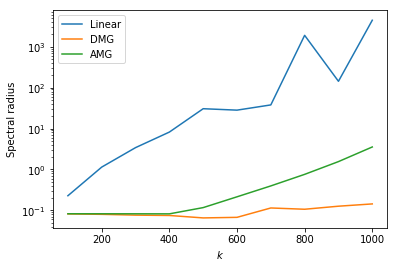

In [8]:
plt.plot(ks, rhos_linear, label="Linear")
plt.plot(ks, rhos_opt, label="DMG")
plt.plot(ks, rhos_amg, label="AMG")
plt.yscale("log")
plt.xlabel("$k$")
plt.ylabel("Spectral radius")
plt.legend()